# **Gradio Installation**

# **Import necessary libraries**

In [38]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output as cls

In [39]:
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [40]:
batch_Size = 32
image_Size = 224
epochs = 10
channels = 3

# **Data spliting**

In [41]:
import os
os.environ["KAGGLE_USERNAME"] = "abdelrahmansaied20"
os.environ["KAGGLE_KEY"] = "ea78e7faac9abf4378bb9b53d0621a73"

In [42]:
# ! kaggle datasets download -d phylake1337/fire-dataset

In [43]:
# !unzip /content/fire-dataset.zip 

In [44]:
data_dir = "/content/fire_dataset"

In [45]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_Size , image_Size ),
  batch_size=batch_Size)

Found 999 files belonging to 2 classes.
Using 800 files for training.


In [46]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_Size , image_Size ),
  batch_size=batch_Size)

Found 999 files belonging to 2 classes.
Using 199 files for validation.


In [47]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [48]:
labels = train_ds.class_names
labels

['fire_images', 'non_fire_images']

# **Data Visualization**

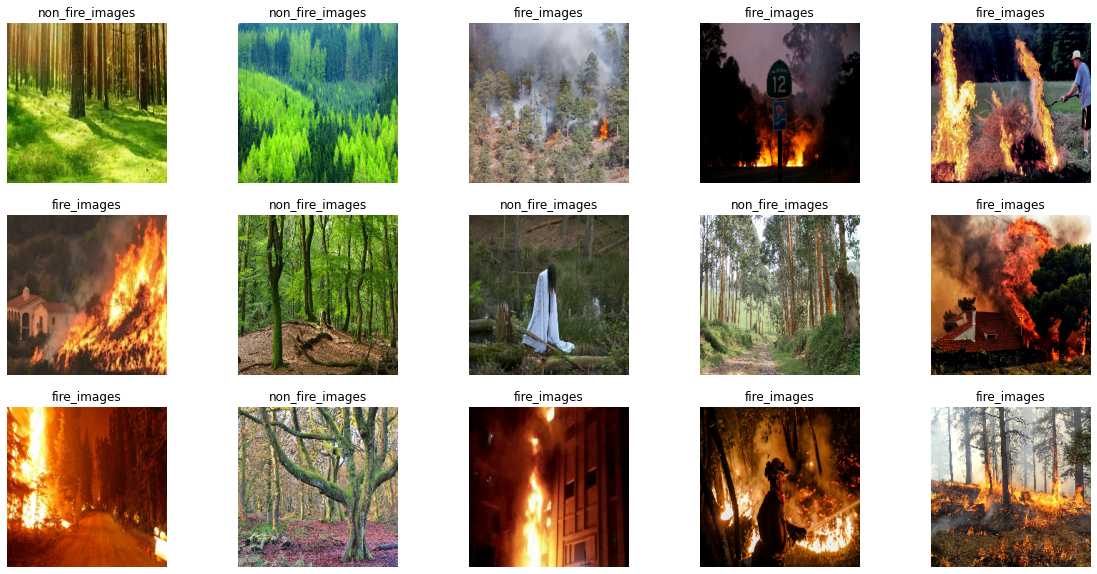

In [49]:
plt.figure(figsize=(20,10))
for imgBatch, labelBatch in train_ds.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i+1)
        plt.imshow(imgBatch[i].numpy().astype('uint8'))
        plt.title(labels[labelBatch[i]])
        plt.axis("off")
        cls()

# **Scaling and Modelling**

In [50]:
scaling = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(224, 224),
    layers.experimental.preprocessing.Rescaling(1./255.)
])

In [51]:
model = Sequential([
    scaling,
    layers.Conv2D(64, kernel_size = (3,3), activation='relu', input_shape=(batch_Size, image_Size, image_Size, channels)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.1),
    layers.Conv2D(128, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.1),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])



In [52]:
# Create checkpoint callback
checkpoint_path = "fires_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [53]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [54]:
model.compile(    optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy']
    )
history = model.fit(train_ds,
                       batch_size=batch_Size,
                       validation_data=val_ds,
                       verbose=1,
                       epochs=epochs,
                        callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "fire_classification"),
        checkpoint_callback,
    ]
    )

Saving TensorBoard log files to: training_logs/fire_classification/20230315-025547
Epoch 1/10
25/25 [==============================] - 229s 9s/step - loss: 0.4054 - accuracy: 0.7412 - val_loss: 0.2833 - val_accuracy: 0.7538
Epoch 2/10
25/25 [==============================] - 231s 9s/step - loss: 0.2979 - accuracy: 0.8625 - val_loss: 0.3134 - val_accuracy: 0.9447
Epoch 3/10
25/25 [==============================] - 224s 9s/step - loss: 0.2654 - accuracy: 0.9375 - val_loss: 0.3415 - val_accuracy: 0.9146
Epoch 4/10
25/25 [==============================] - 226s 9s/step - loss: 0.2752 - accuracy: 0.9325 - val_loss: 0.2192 - val_accuracy: 0.9648
Epoch 5/10
25/25 [==============================] - 231s 9s/step - loss: 0.2192 - accuracy: 0.9525 - val_loss: 0.1970 - val_accuracy: 0.9648
Epoch 6/10
25/25 [==============================] - 224s 9s/step - loss: 0.1916 - accuracy: 0.9450 - val_loss: 0.1315 - val_accuracy: 0.9598
Epoch 7/10
25/25 [==============================] - 231s 9s/step - loss

# **Visualized Evaluation**

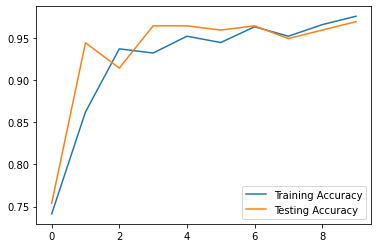

In [55]:
plt.plot(history.history['accuracy'] ,label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Testing Accuracy')
plt.legend()

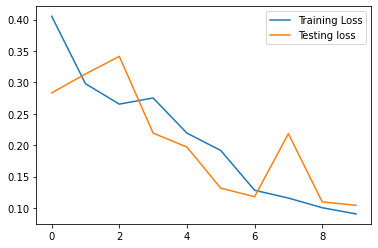

In [56]:

plt.plot(history.history['loss'] ,label='Training Loss')
plt.plot(history.history['val_loss'],label='Testing loss')
plt.legend()

In [57]:
def PredictIMG(data, classes, model):
    
    for imgs, lab in iter(data):
        label = np.array(lab)
        
        for i in range(len(imgs)):
            
            img = tf.expand_dims(imgs[i], axis=0)
            Tlab = classes[label[i]]
            
            pred = model.predict(img)[0]
            pred = 1 if pred>0.5 else 0
            predlab = classes[pred]
#             title = f"True : {lab}\nPred : {predlab}"
#             print("true: ",Tlab, "pred: ",predlab)
        
            
    

In [58]:
PredictIMG(val_ds, labels, model)

1/1 [==============================] - 0s 128ms/step


In [59]:
model.evaluate(val_ds)

7/7 [==============================] - 16s 2s/step - loss: 0.1042 - accuracy: 0.9698


[0.1041722521185875, 0.9698492288589478]

In [60]:
model.save("model.h5")

# **Gradio ETE Modelization**

In [64]:
def predict_input_image(img):
    class_names = ['fire_images', 'non_fire_images']
    img_4d=img.reshape(-1,196, 196,3)
    prediction=model.predict(img_4d)[0]
    if prediction>0.5:
        pred = [1-prediction, prediction]
    else:
         pred = [1-prediction, prediction]
#     predlab = classes[pred]
    
    confidences = {class_names[i]: float(pred[i]) for i in range(2)}
    print()
    return confidences

In [66]:
import gradio as gr


ModuleNotFoundError: ignored

In [65]:
image = gr.inputs.Image(shape=(196, 196))
label = gr.outputs.Label(num_top_classes=1)

NameError: ignored

In [63]:
gr.Interface(fn=predict_input_image, 
inputs=image, outputs=label,interpretation='default').launch(debug='True', share='True')